# GyroAI-SAT (v1)

Notebook simplificado para análise de orientação e Gimbal Lock usando dados TLE.

In [1]:
from sgp4.api import Satrec
from datetime import datetime, timedelta
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
# TLE da ISS (pode ser trocado por outro)
line1 = '1 25544U 98067A   24106.45347222  .00012190  00000+0  21377-3 0  9992'
line2 = '2 25544  51.6414  52.8843 0003046  96.6780  42.0736 15.51762384294959'

def datetime_to_julian_date(dt):
    year, month, day = dt.year, dt.month, dt.day
    hour, minute = dt.hour, dt.minute
    second = dt.second + dt.microsecond / 1e6
    jd = 367 * year - int((7 * (year + int((month + 9) / 12))) / 4)          + int((275 * month) / 9) + day + 1721013.5          + (hour + minute / 60 + second / 3600) / 24
    fr = (hour + minute / 60 + second / 3600) / 24 % 1
    return jd, fr


In [4]:
sat = Satrec.twoline2rv(line1, line2)

base_time = datetime.utcnow()
interval = 30  # segundos
samples = 300

dados = []

for i in range(samples):
    dt = base_time + timedelta(seconds=i * interval)
    jd, fr = datetime_to_julian_date(dt)
    e, r, v = sat.sgp4(jd, fr)
    if e != 0:
        continue
    r = np.array(r)
    v = np.array(v)

    z = -r / np.linalg.norm(r)
    y = np.cross(z, v)
    y /= np.linalg.norm(y)
    x = np.cross(y, z)
    rot_matrix = np.vstack([x, y, z]).T
    rotation = R.from_matrix(rot_matrix)

    quat = rotation.as_quat()  # x, y, z, w
    quat = np.roll(quat, 1)    # w, x, y, z
    euler = rotation.as_euler('xyz', degrees=True)

    dados.append({
        'tempo': i * interval,
        'x': r[0], 'y': r[1], 'z': r[2],
        'vx': v[0], 'vy': v[1], 'vz': v[2],
        'roll': euler[0], 'pitch': euler[1], 'yaw': euler[2],
        'q0': quat[0], 'q1': quat[1], 'q2': quat[2], 'q3': quat[3]
    })

print(f"Total de amostras: {len(dados)}")

Total de amostras: 300


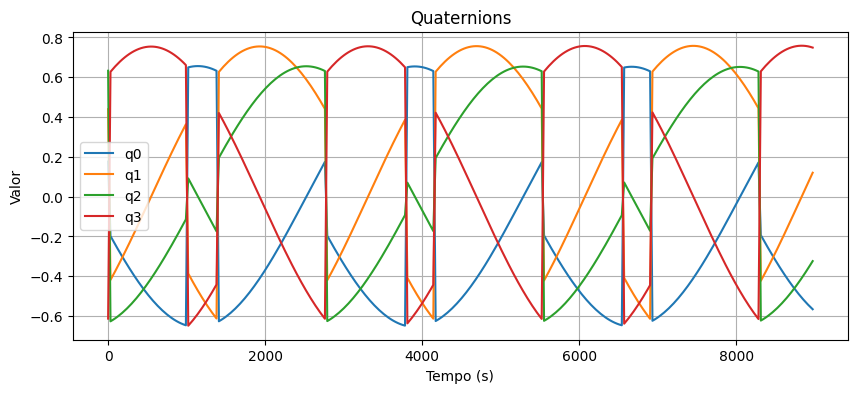

In [5]:
t = [d['tempo'] for d in dados]
q0 = [d['q0'] for d in dados]
q1 = [d['q1'] for d in dados]
q2 = [d['q2'] for d in dados]
q3 = [d['q3'] for d in dados]

plt.figure(figsize=(10, 4))
plt.plot(t, q0, label="q0")
plt.plot(t, q1, label="q1")
plt.plot(t, q2, label="q2")
plt.plot(t, q3, label="q3")
plt.title("Quaternions")
plt.xlabel("Tempo (s)")
plt.ylabel("Valor")
plt.grid()
plt.legend()
plt.show()


In [6]:
# Detecção simples de gimbal lock com base no pitch
for d in dados:
    pitch = abs(d['pitch'])
    if 85 < pitch < 95:
        d['status'] = "GIMBAL LOCK"
    elif 75 < pitch <= 85 or 95 <= pitch < 105:
        d['status'] = "ALERTA"
    else:
        d['status'] = "OK"

# Mostrar os primeiros com alerta ou GIMBAL
[d for d in dados if d['status'] != 'OK'][:5]


[]

In [7]:
# Placeholder: IA simples baseada no status atual
def simular_ia(pitch):
    if 85 < abs(pitch) < 95:
        return "GIMBAL LOCK"
    elif 75 < abs(pitch) <= 85 or 95 <= abs(pitch) < 105:
        return "ALERTA"
    return "OK"

# Teste de IA
for d in dados[:5]:
    print(f"Pitch: {d['pitch']:.2f}°, IA: {simular_ia(d['pitch'])}")


Pitch: 49.62°, IA: OK
Pitch: 50.60°, IA: OK
Pitch: 51.27°, IA: OK
Pitch: 51.62°, IA: OK
Pitch: 51.62°, IA: OK
